# Can We Predict Political Stability Through Use of Global Sustainability Goal Indicators? 

In 2015, all UN Member States developed a set of 17 Global Sustainability Goals to allow for peace and prosperity globally.  The set of goals include those to reduce poverity and inequality, improve health and education, increase economic growth, increase access to clean water and food, and do so in a manner that protects the land and oceans.  

Climate change induced floods and droughts, poverity, and lack of access to clean water and food all contribute to political tension and violence as people struggle to meet their basic needs.  The goal of this project is to see how well the country status of each sustainable development goal can be used to predict the political stability and absence of violence for each country. 

The Sustainability Goals data were obtained from World Bank:https://api.worldbank.org/v2/sources/46/indicators
Documentation on the Sustainability Goals can be found here: https://datatopics.worldbank.org/sdgatlas/
The Worldwide Governance Indicators data were obtaiend from World Bank: https://datacatalog.worldbank.org/dataset/worldwide-governance-indicators.  Details on the selected variables from each dataset can be found below. 



## Get Response Variable: Political Stability and Absence of Violence/Terrorism

In [5]:
# Importing necessary packages
import pandas as pd
import numpy as np
import datetime
import wbdata
import plotly.express as px
import plotly.io as pio
import requests

In [6]:
# Requesting the indicators for the topic Political Stability. The 3 is the key for the Political Stability Data.
indicators = requests.get("http://api.worldbank.org/v2/indicator?format=json&source=3")
indicatorsJSON = indicators.json()

In [7]:
# Get all Worldwide Governance indicators so we know what is available
indicators = requests.get("http://api.worldbank.org/v2/indicator?format=json&source=3&per_page=500")
indicatorsJSON = indicators.json()
#print(indicatorsJSON) # to view ALL of the indicators as is, remove the "#" at the beginning of the print command

# Parse through the response to see the Indicator IDs and Names
for i in indicatorsJSON[1]:
    IDSindicators = (i["id"],i["name"])
    print(IDSindicators) # to view the indicator ids and names, remove the "#" at the beginning of the print command

('CC.EST', 'Control of Corruption: Estimate')
('CC.NO.SRC', 'Control of Corruption: Number of Sources')
('CC.PER.RNK', 'Control of Corruption: Percentile Rank')
('CC.PER.RNK.LOWER', 'Control of Corruption: Percentile Rank, Lower Bound of 90% Confidence Interval')
('CC.PER.RNK.UPPER', 'Control of Corruption: Percentile Rank, Upper Bound of 90% Confidence Interval')
('CC.STD.ERR', 'Control of Corruption: Standard Error')
('GE.EST', 'Government Effectiveness: Estimate')
('GE.NO.SRC', 'Government Effectiveness: Number of Sources')
('GE.PER.RNK', 'Government Effectiveness: Percentile Rank')
('GE.PER.RNK.LOWER', 'Government Effectiveness: Percentile Rank, Lower Bound of 90% Confidence Interval')
('GE.PER.RNK.UPPER', 'Government Effectiveness: Percentile Rank, Upper Bound of 90% Confidence Interval')
('GE.STD.ERR', 'Government Effectiveness: Standard Error')
('PV.EST', 'Political Stability and Absence of Violence/Terrorism: Estimate')
('PV.NO.SRC', 'Political Stability and Absence of Violence

In [8]:
# Use the indicator code to define the "indicator" variable.  We can change this to get information on each of the indicators.
indicator = "PV.STD.ERR"

# Parse through the response to get the "sourceNote" or definition for the desired indicator
for dict_entity in indicatorsJSON[1]:
    if dict_entity["id"] == indicator:
        print(dict_entity["sourceNote"])
    else:
        pass

Political Stability and Absence of Violence/Terrorism measures perceptions of the likelihood of political instability and/or politically-motivated violence, including terrorism.  Standard error indicates the precision of the estimate of governance.  Larger values of the standard error indicate less precise estimates.  A 90 percent confidence interval for the governance estimate is given by the estimate +/- 1.64 times the standard error.


In [10]:
#Get a list of all the location abbreviations so we know what they are for limiting selections.
dlocations = requests.get("http://api.worldbank.org/v2/sources/3/country?per_page=300&format=JSON")
dlocationsJSON = dlocations.json()

# Parse through the response to see the location IDs and names
dlocations = dlocationsJSON["source"][0]["concept"][0]["variable"]
listLen = int(len(dlocations))

# Create dataframe with location values
df = pd.DataFrame(columns=["id", "country"])     
for i in range(0,listLen):
    code = dlocations[i]["id"]
    name = dlocations[i]["value"]
    df = df.append({"id":code, "country":name}, ignore_index = True)
dlocationsList = df

# See first few items in the dataframe
dlocationsList.head()

,id,country
0,ABW,Aruba
1,AFG,Afghanistan
2,AGO,Angola
3,AIA,Anguilla
4,ALB,Albania


In [11]:
#Select the indicator, location, and time you would like for the API call
# Selecting the indicator
indicatorSelection = {'PV.EST':'Political Stability and Absence of Violence/Terrorism: Estimate',
                     'PV.STD.ERR': 'Political Stability and Absence of Violence/Terrorism: Standard Error'}
# Select the countries or regions
locationSelection = ["all"]
# Selecting the time frame
timeSelection = (datetime.datetime(2010, 1, 1), datetime.datetime(2020, 12, 31))
#Set the source id number for the Worldwide Governance Data
source_id=3

In [12]:
# Make the API call and assign the resulting DataFrame to "PT_data"
#Notes from wbdata: 
"""
    Convenience function to download a set of indicators and  merge them into a
        pandas DataFrame.  The index will be the same as if calls were made to
        get_data separately.
    :indicators: A dictionary where the keys are desired indicators and the
        values are the desired column names
    :country: a country code, sequence of country codes, or "all" (default)
    :data_date: the desired date as a datetime object or a 2-sequence with
        start and end dates
    :freq: the desired periodicity of the data, one of 'Y' (yearly), 'M'
        (monthly), or 'Q' (quarterly). The indicator may or may not support the
        specified frequency.
    :source: the specific source to retrieve data from (defaults on API to 2,
        World Development Indicators)
    :convert_date: if True, convert date field to a datetime.datetime object.
    :keep_levels: if True don't reduce the number of index levels returned if
        only getting one date or country
    :cache: use the cache
    :returns: a WBDataFrame
    """
PT_data = wbdata.get_dataframe(indicatorSelection,
                            source=source_id,
                            country = locationSelection, 
                            data_date = timeSelection, 
                            convert_date = False)

In [13]:
PT_data.head()

Political Stability and Absence of Violence/Terrorism: Estimate  \
country     date                                                                    
Afghanistan 2019                                          -2.649407                 
            2018                                          -2.751611                 
            2017                                          -2.800609                 
            2016                                          -2.671054                 
            2015                                          -2.571222                 

                  Political Stability and Absence of Violence/Terrorism: Standard Error  
country     date                                                                         
Afghanistan 2019                                           0.241833                      
            2018                                           0.226781                      
            2017                                           0.227994                      
            2016                                           0.219708                      
            2015                                           0.215604

In [14]:
# Turn multiindex into columns
PT_data.reset_index(inplace=True)  
PT_data.head()

,country,date,Political Stability and Absence of Violence/Terrorism: Estimate,Political Stability and Absence of Violence/Terrorism: Standard Error
0,Afghanistan,2019,-2.649407,0.241833
1,Afghanistan,2018,-2.751611,0.226781
2,Afghanistan,2017,-2.800609,0.227994
3,Afghanistan,2016,-2.671054,0.219708
4,Afghanistan,2015,-2.571222,0.215604


In [15]:
#Merge Political Stability data with dlocationsList to get the ISO code for each country
PT_data_with_loc = pd.merge(dlocationsList, PT_data, on='country')
PT_data_with_loc.head(-1)

,id,country,date,Political Stability and Absence of Violence/Terrorism: Estimate,Political Stability and Absence of Violence/Terrorism: Standard Error
0,ABW,Aruba,2019,1.357372,0.271196
1,ABW,Aruba,2018,1.362981,0.251480
2,ABW,Aruba,2017,1.334757,0.254837
3,ABW,Aruba,2016,1.284199,0.244329
4,ABW,Aruba,2015,1.230921,0.241163
...,...,...,...,...,...
2134,ZWE,Zimbabwe,2015,-0.618156,0.202983
2135,ZWE,Zimbabwe,2014,-0.713570,0.196386
2136,ZWE,Zimbabwe,2013,-0.665950,0.228020
2137,ZWE,Zimbabwe,2012,-0.778662,0.221984


In [16]:
#make fucntion to get lat and lon of each country for plotting from country code
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent="http")

def get_lat(country):
    try:
        # Geolocate the center of the country
        loc = geolocator.geocode(country)
        # And return latitude and longitude
        return loc.latitude
    except:
        # Return missing value
        return np.nan
    
def get_lon(country):
    try:
        # Geolocate the center of the country
        loc = geolocator.geocode(country)
        # And return latitude and longitude
        return loc.longitude
    except:
        # Return missing value
        return np.nan

In [17]:
# Remove countries with no Political tension data
PT_data_with_loc.dropna(axis=0, inplace=True)
PT_data_with_loc.head()

,id,country,date,Political Stability and Absence of Violence/Terrorism: Estimate,Political Stability and Absence of Violence/Terrorism: Standard Error
0,ABW,Aruba,2019,1.357372,0.271196
1,ABW,Aruba,2018,1.362981,0.251480
2,ABW,Aruba,2017,1.334757,0.254837
3,ABW,Aruba,2016,1.284199,0.244329
4,ABW,Aruba,2015,1.230921,0.241163


In [18]:
#get length of the dataset
len(PT_data_with_loc)

2114

In [19]:
# Make a new dataframe storing the country name, country code, lat and lon for each country to use with other datasets
country_data = PT_data_with_loc.drop(['Political Stability and Absence of Violence/Terrorism: Estimate', 'Political Stability and Absence of Violence/Terrorism: Standard Error'], axis=1)
country_df = country_data.drop('date', axis=1)
country_df.drop_duplicates(['country'], inplace=True)

In [20]:
len(country_df)

214

In [21]:
#Get Lat lon of each country based on id using function above.

country_df['lat'] = country_df.apply(lambda row : get_lat(row['country']), axis=1)
country_df['lon'] = country_df.apply(lambda row : get_lon(row['country']), axis=1)

country_df.head()

,id,country,lat,lon
0,ABW,Aruba,12.490300,-69.960984
10,AFG,Afghanistan,33.768006,66.238514
20,AGO,Angola,-11.877577,17.569124
30,AIA,Anguilla,18.195495,-63.075023
40,ALB,Albania,41.000028,19.999962


In [22]:
#Remove any countries with nan values for lat or lon
country_df.dropna(axis=0, inplace=True)
country_df.head()

,id,country,lat,lon
0,ABW,Aruba,12.490300,-69.960984
10,AFG,Afghanistan,33.768006,66.238514
20,AGO,Angola,-11.877577,17.569124
30,AIA,Anguilla,18.195495,-63.075023
40,ALB,Albania,41.000028,19.999962


In [23]:
#merge country_df and co2_data now that we have lat lon for each country
PT_new_df = pd.merge(PT_data_with_loc, country_df, on='country')
PT_new_df.head()

,id_x,country,date,Political Stability and Absence of Violence/Terrorism: Estimate,Political Stability and Absence of Violence/Terrorism: Standard Error,id_y,lat,lon
0,ABW,Aruba,2019,1.357372,0.271196,ABW,12.4903,-69.960984
1,ABW,Aruba,2018,1.362981,0.251480,ABW,12.4903,-69.960984
2,ABW,Aruba,2017,1.334757,0.254837,ABW,12.4903,-69.960984
3,ABW,Aruba,2016,1.284199,0.244329,ABW,12.4903,-69.960984
4,ABW,Aruba,2015,1.230921,0.241163,ABW,12.4903,-69.960984


In [24]:
#remove extra id column
PT_new_df.drop('id_y', axis=1, inplace=True)
PT_new_df.head()

,id_x,country,date,Political Stability and Absence of Violence/Terrorism: Estimate,Political Stability and Absence of Violence/Terrorism: Standard Error,lat,lon
0,ABW,Aruba,2019,1.357372,0.271196,12.4903,-69.960984
1,ABW,Aruba,2018,1.362981,0.251480,12.4903,-69.960984
2,ABW,Aruba,2017,1.334757,0.254837,12.4903,-69.960984
3,ABW,Aruba,2016,1.284199,0.244329,12.4903,-69.960984
4,ABW,Aruba,2015,1.230921,0.241163,12.4903,-69.960984


In [25]:
#Change df column names for easier processing
PT_new_df.rename(columns={"Political Stability and Absence of Violence/Terrorism: Estimate": "Political_Stability", "Political Stability and Absence of Violence/Terrorism: Standard Error": "Political_Stability_SE", "id_x": "id"}, inplace=True)
PT_new_df.head()

,id,country,date,Political_Stability,Political_Stability_SE,lat,lon
0,ABW,Aruba,2019,1.357372,0.271196,12.4903,-69.960984
1,ABW,Aruba,2018,1.362981,0.251480,12.4903,-69.960984
2,ABW,Aruba,2017,1.334757,0.254837,12.4903,-69.960984
3,ABW,Aruba,2016,1.284199,0.244329,12.4903,-69.960984
4,ABW,Aruba,2015,1.230921,0.241163,12.4903,-69.960984


In [26]:
#Find the 10 year mean political stability of each country
grouped_PT_df = PT_new_df.groupby('country').mean().reset_index()
grouped_PT_df[grouped_PT_df['country']=='United States']

,country,Political_Stability,Political_Stability_SE,lat,lon
196,United States,0.507555,0.216898,39.78373,-100.445883


# Remove any Countries with High Standard Error for Estimates of Political Stability

Countries that have a high standard error for estimates of political stability have low precision of the estimate of governance.  Larger values of the standard error indicate less precise estimates.  A 90 percent confidence interval for the governance estimate is given by the estimate +/- 1.64 times the standard error.  We only want to include countries that have precise estimates for political stability because we want our model to use measures of global sustainability indicators to predict the countries actual political stability. 

In [27]:
#Remove any outliers for high Standard Error
# calculate summary statistics
data_mean, data_std = np.mean(PT_new_df['Political_Stability_SE']), np.std(PT_new_df['Political_Stability_SE'])
# identify outliers
cut_off = data_std * 3
lower, upper = data_mean - cut_off, data_mean + cut_off
print(lower, upper)

0.057320212486564576 0.434299477877251


In [28]:
# remove outliers with standard error higher than three standard deviations about the mean standard error
PT_new_df = PT_new_df[(PT_new_df['Political_Stability_SE'] < upper)]

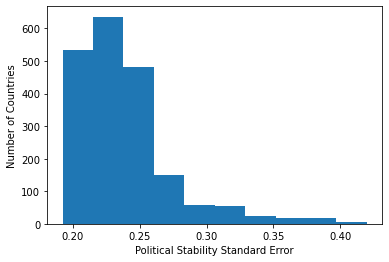

In [30]:
#plot histogram of the Standard Error
import matplotlib.pyplot as plt

plt.hist(PT_new_df['Political_Stability_SE'])
PT_new_df['Political_Stability_SE'].describe()
plt.xlabel("Political Stability Standard Error")
plt.ylabel("Number of Countries")
plt.show()

The dataset now only includes countries with max standard error in the dataset of 0.42.

In [31]:
#Sort the dataset on the 10 year mean political stability values from highest to lowest
grouped_PT_df.sort_values('Political_Stability', ascending=False)

,country,Political_Stability,Political_Stability_SE,lat,lon
71,Greenland,1.903959,0.382400,77.619235,-42.812597
105,Liechtenstein,1.480630,0.269135,47.141631,9.553153
132,New Zealand,1.457606,0.216898,-41.500083,172.834408
91,"Jersey, Channel Islands",1.399630,0.485580,49.185217,-2.109048
163,Singapore,1.374209,0.216898,1.357107,103.819499
...,...,...,...,...,...
85,Iraq,-2.247403,0.231976,33.095579,44.174978
179,Syrian Arab Republic,-2.490038,0.229933,34.640186,39.049411
140,Pakistan,-2.504352,0.220594,30.330840,71.247499
0,Afghanistan,-2.587409,0.238639,33.768007,66.238514


The top five countries with high political stability estimates are Greenland, Liechtenstein, New Zealand, Jersey, Channel Islands, and Singapore.  The lowest political stability estimates are Iraq, Syrian Arab Republic, Pakistan, Afghanistan and Somalia. 

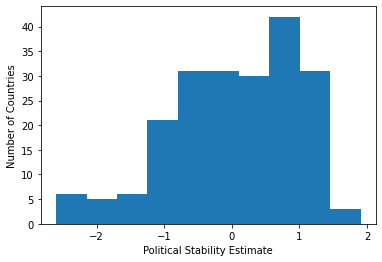

In [32]:
#Show a histogram of 5-year mean political stability. 
plt.hist(x="Political_Stability", data=grouped_PT_df)
plt.xlabel("Political Stability Estimate")
plt.ylabel("Number of Countries")
plt.show()

# Graph the Political Stability Values on a Map

In [104]:
#Change names of several countries to match the country name listed in the geopandas shapefile
modified_country_df = grouped_PT_df
boolean_condition = grouped_PT_df.country == 'United States'
column_name = 'country'
new_value = 'United States of America'
modified_country_df.loc[boolean_condition, column_name] = new_value

boolean_condition = grouped_PT_df.country == 'Russian Federation'
column_name = 'country'
new_value = 'Russia'
modified_country_df.loc[boolean_condition, column_name] = new_value

boolean_condition = grouped_PT_df.country == 'Venezuela, RB'
column_name = 'country'
new_value = 'Venezuela'
modified_country_df.loc[boolean_condition, column_name] = new_value

boolean_condition = grouped_PT_df.country == 'Syrian Arab Republic'
column_name = 'country'
new_value = 'Syria'
modified_country_df.loc[boolean_condition, column_name] = new_value

,country,Political_Stability,Political_Stability_SE,lat,lon
0,Afghanistan,-2.587409,0.238639,33.768007,66.238514
1,Albania,0.152647,0.223305,41.000028,19.999962
2,Algeria,-1.127140,0.224624,28.000027,2.999983
3,American Samoa,1.077233,0.353393,-14.289304,-170.692511
4,Andorra,1.370702,0.314217,42.540717,1.573203


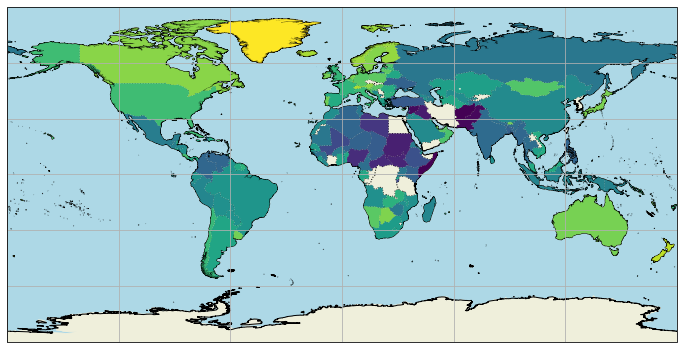

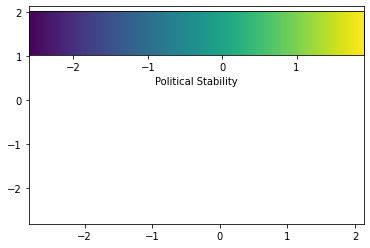

In [257]:
import cartopy
from cartopy.io import shapereader
import cartopy.crs as ccrs
import geopandas
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# get country borders
resolution = '10m'
category = 'cultural'
name = 'admin_0_countries'
shpfilename = shapereader.natural_earth(resolution, category, name)

# read the shapefile using geopandas
df = geopandas.read_file(shpfilename)

# Set up the canvas
fig = plt.figure(figsize=(12, 12))
central_lon = 0 
ax = plt.axes(projection=cartopy.crs.PlateCarree(central_lon))
ax.gridlines()

# Add borders, ocean, and land features
ax.add_feature(cartopy.feature.BORDERS, linestyle=':', alpha=1)
ax.add_feature(cartopy.feature.OCEAN, facecolor=("lightblue"))
ax.add_feature(cartopy.feature.LAND)
ax.coastlines(resolution='10m')

# Define the list of countries we want to map
countries = modified_country_df['country']

#Define the political stability values for each country
ps = modified_country_df['Political_Stability']

# Normalise the political stability values to between 0 and 1 to extract the colour
ps_norm = (ps-np.nanmin(ps))/(np.nanmax(ps) - np.nanmin(ps))

# Choose the colormap
cmap = plt.cm.get_cmap('viridis')

#loop through each country and political stability value and plot them
for country, ps_norm in zip(countries, ps_norm):
    # read the borders of the country in this loop
    #Exclude some countries whose names are not in the geopandas shapefile
    exclude_list = ['Bahamas, The', 'Brunei Darussalam', "Cote d'Ivoire", "Czech Republic", "Eswatini", "French Guiana", "Gambia, The", "Hong Kong SAR, China", "Jersey, Channel Islands", "Kyrgyz Republic", "Lao PDR", "Macao SAR, China", "Martinique", "Netherlands Antilles", "North Macedonia", "Reunion", "Sao Tome and Principe", "Serbia", "Slovak Republic", "St. Kitts and Nevis", "St. Lucia", "St. Vincent and the Grenadines", "Taiwan, China", "Tanzania", "Timor-Leste", "Virgin Islands (U.S.)", "West Bank and Gaza"]
    if country not in exclude_list:
        poly = df.loc[df['ADMIN'] == country]['geometry'].values[0]
        # get the color for this country
        rgba = cmap(ps_norm)
        # plot the country on a map
        ax.add_geometries([poly], crs=ccrs.PlateCarree(), facecolor=rgba, edgecolor='none', zorder=1)

# Add a scatter plot of the original data so the colorbar has the correct numbers.
#fig, ax = plt.subplots(2,1,figsize=(16,9), gridspec_kw={'height_ratios': [2, 1]})
fig, ax = plt.subplots()

dummy_scat = ax.scatter(ps, ps, c=ps, cmap=cmap, zorder=0)
dummy_scat.set_visible(False)
axins1 = inset_axes(ax,
                    width="100%",  
                    height="20%", 
                    loc='upper center')
fig.colorbar(mappable=dummy_scat, label='Political Stability', orientation='horizontal', cax=axins1)
  

In [125]:
#Try to find the name of the countries in the shapefile that are in the exclude list above
newdf = df.loc[(df.ADMIN == "Gaza")]
newdf.head()

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,ADMIN,ADM0_A3,...,NAME_KO,NAME_NL,NAME_PL,NAME_PT,NAME_RU,NAME_SV,NAME_TR,NAME_VI,NAME_ZH,geometry


# Get Predictor Variables from Sustainability Goals Dataset

In [126]:
# Requesting the indicators for the topic Political Stability.  The 46 is the key for the Political Stability Data.
indicators = requests.get("http://api.worldbank.org/v2/indicator?format=json&source=46")
indicatorsJSON = indicators.json()

In [127]:
# Get all Sustainable Development Variables so we know what is available
indicators = requests.get("http://api.worldbank.org/v2/indicator?format=json&source=46&per_page=500")
indicatorsJSON = indicators.json()
#print(indicatorsJSON) # to view ALL of the indicators as is, remove the "#" at the beginning of the print command

# Parse through the response to see the Indicator IDs and Names
for i in indicatorsJSON[1]:
    IDSindicators = (i["id"],i["name"])
    print(IDSindicators) # to view the indicator ids and names, remove the "#" at the beginning of the print command

('AG.LND.FRST.K2', 'Forest area (sq. km)')
('AG.LND.FRST.ZS', 'Forest area (% of land area)')
('AG.YLD.CREL.KG', 'Cereal yield (kg per hectare)')
('BN.CAB.XOKA.GD.ZS', 'Current account balance (% of GDP)')
('BN.KLT.PTXL.CD', 'Portfolio Investment, net (BoP, current US$)')
('BX.KLT.DINV.CD.WD', 'Foreign direct investment, net inflows (BoP, current US$)')
('BX.KLT.DINV.WD.GD.ZS', 'Foreign direct investment, net inflows (% of GDP)')
('BX.TRF.PWKR.DT.GD.ZS', 'Personal remittances, received (% of GDP)')
('DT.DOD.DECT.GN.ZS', 'External debt stocks (% of GNI)')
('DT.ODA.ALLD.CD', 'Net official development assistance and official aid received (current US$)')
('DT.ODA.ODAT.CD', 'Net official development assistance received (current US$)')
('DT.ODA.ODAT.CD1', 'Net official development assistance received (current US$)')
('DT.ODA.ODAT.KD', 'Net official development assistance received (constant 2018 US$)')
('DT.TDS.DPPF.XP.ZS', 'Debt service (PPG and IMF only, % of exports of goods, services and 

In [128]:
# Use the indicator code to define the "indicator" variable.  We can change this to get information on each of the indicators.
indicator = "SH.SVR.WAST.FE.ZS"

# Parse through the response to get the "sourceNote" or definition for the desired indicator
for dict_entity in indicatorsJSON[1]:
    if dict_entity["id"] == indicator:
        print(dict_entity["sourceNote"])
    else:
        pass

Prevalence of severe wasting, female, is the proportion of girls under age 5 whose weight for height is more than three standard deviations below the median for the international reference population ages 0-59.


In [129]:
#Get a list of all the location abbreviations from the sustainable development dataset so we know what they are for limiting selections.
dlocations = requests.get("http://api.worldbank.org/v2/sources/46/country?per_page=300&format=JSON")
dlocationsJSON = dlocations.json()

# Parse through the response to see the location IDs and names
dlocations = dlocationsJSON["source"][0]["concept"][0]["variable"]
listLen = int(len(dlocations))

# Create dataframe with location values
df = pd.DataFrame(columns=["id", "country"])     
for i in range(0,listLen):
    code = dlocations[i]["id"]
    name = dlocations[i]["value"]
    df = df.append({"id":code, "country":name}, ignore_index = True)
dlocationsList = df

# See first few items in the dataframe
dlocationsList.head()

,id,country
0,ABW,Aruba
1,AFG,Afghanistan
2,AGO,Angola
3,ALB,Albania
4,AND,Andorra


In [130]:
#Set a list of all the predictor variables that we want to use from the dataset. 
predictor_variables = []

In [131]:
#Select the indicator, location, and time you would like for the API call
# Selecting the indicator
indicatorSelection = {'AG.LND.FRST.ZS':'Forest area (% of land area)', 
                      'AG.YLD.CREL.KG':'Cereal yield (kg per hectare)',
                      'BN.CAB.XOKA.GD.ZS':'Current account balance (% of GDP)', 
                      'BX.KLT.DINV.WD.GD.ZS':'Foreign direct investment, net inflows (% of GDP)',
                      'DT.ODA.ALLD.CD':'Net official development assistance and official aid received (current US$)',
                      'EG.CFT.ACCS.ZS':'Access to clean fuels and technologies for cooking (% of population)',
                      'EG.ELC.ACCS.ZS':'Access to electricity (% of population)',
                      'EG.ELC.RNEW.ZS':'Renewable electricity output (% of total electricity output)',
                      'EN.ATM.CO2E.PC':'CO2 emissions (metric tons per capita)',
                      'EN.ATM.PM25.MC.ZS':'PM2.5 air pollution, population exposed to levels exceeding WHO guideline value (% of total)',
                      'EN.MAM.THRD.NO':'Mammal species, threatened',
                      'EN.POP.SLUM.UR.ZS':'Population living in slums (% of urban population)',
                      'ER.H2O.FWST.ZS':'Level of water stress: freshwater withdrawal as a proportion of available freshwater resources',
                      'ER.H2O.INTR.PC':'Renewable internal freshwater resources per capita (cubic meters)',
                      'ER.LND.PTLD.ZS':'Terrestrial protected areas (% of total land area)',
                      'FB.CBK.BRCH.P5':'Commercial bank branches (per 100,000 adults)',
                      'FM.LBL.BMNY.ZG':'Broad money growth (annual %)',
                      'FP.CPI.TOTL.ZG':'Inflation, consumer prices (annual %)',
                      'FX.OWN.TOTL.ZS':'Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+)',
                      'FX.OWN.TOTL.FE.ZS':'Account ownership at a financial institution or with a mobile-money-service provider, female (% of population ages 15+)',
                      'GB.XPD.RSDV.GD.ZS':'Research and development expenditure (% of GDP)',
                      'GC.TAX.TOTL.GD.ZS':'Tax revenue (% of GDP)',
                      'IC.BUS.NDNS.ZS':'New business density (new registrations per 1,000 people ages 15-64)',
                      'IE.PPI.ENGY.CD':'Investment in energy with private participation (current US$)',
                      'IE.PPI.WATR.CD':'Investment in water and sanitation with private participation (current US$)',
                      'IT.NET.USER.ZS':'Individuals using the Internet (% of population)',
                      'NE.EXP.GNFS.KD.ZG':'Exports of goods and services (annual % growth)',
                      'NE.EXP.GNFS.ZS':'Exports of goods and services (% of GDP)',
                      'NE.IMP.GNFS.KD.ZG':'Imports of goods and services (annual % growth)',
                      'NY.GDP.MKTP.CD':'GDP (current US$)',
                      'NY.GDP.MKTP.KD.ZG':'GDP growth (annual %)',
                      'NY.GDP.PCAP.CD':'GDP per capita (current US$)',
                      'NY.GDP.PCAP.KD.ZG':'GDP per capita growth (annual %)',
                      'SE.ADT.1524.LT.FE.ZS':'Literacy rate, youth female (% of females ages 15-24)',
                      'SE.ADT.LITR.ZS':'Literacy rate, adult total (% of people ages 15 and above)',
                      'SE.PRE.ENRR':'School enrollment, preprimary (% gross)',
                      'SE.ENR.PRSC.FM.ZS':'School enrollment, primary and secondary (gross), gender parity index (GPI)',
                      'SE.SEC.CMPT.LO.ZS':'Lower secondary completion rate, total (% of relevant age group)',
                      'SE.SEC.CUAT.PO.FE.ZS':'Educational attainment, at least completed post-secondary, population 25+, female (%) (cumulative)',
                      'SE.TER.CUAT.BA.ZS':"Educational attainment, at least Bachelor's or equivalent, population 25+, total (%) (cumulative)",
                      'SE.SEC.UNER.LO.ZS':'Adolescents out of school (% of lower secondary school age)',
                      'SH.ALC.PCAP.LI':'Total alcohol consumption per capita (liters of pure alcohol, projected estimates, 15+ years of age)',
                      'SH.ANM.ALLW.ZS':'Prevalence of anemia among women of reproductive age (% of women ages 15-49)',
                      'SH.DYN.AIDS.ZS':'Prevalence of HIV, total (% of population ages 15-49)',
                      'SH.DYN.MORT':'Mortality rate, under-5 (per 1,000 live births)',
                      'SH.DYN.NCOM.ZS':'Mortality from CVD, cancer, diabetes or CRD between exact ages 30 and 70 (%)',
                      'SH.DYN.NMRT':'Mortality rate, neonatal (per 1,000 live births)',
                      'SH.H2O.BASW.ZS':'People using at least basic drinking water services (% of population)',
                      'SH.H2O.SMDW.ZS':'People using safely managed drinking water services (% of population)',
                      'SH.STA.FGMS.ZS':'Female genital mutilation prevalence (%)',
                      'SH.STA.MALN.ZS':'Prevalence of underweight, weight for age (% of children under 5)',
                      'SH.STA.SUIC.P5':'Suicide mortality rate (per 100,000 population)',
                      'SH.UHC.OOPC.10.ZS':'Proportion of population spending more than 10% of household consumption or income on out-of-pocket health care expenditure (%)',
                      'SL.UEM.TOTL.ZS':'Unemployment, total (% of total labor force) (modeled ILO estimate)',
                      'SN.ITK.MSFI.ZS':'Prevalence of moderate or severe food insecurity in the population (%)',
                      'SP.M18.2024.FE.ZS':'Women who were first married by age 18 (% of women ages 20-24)',
                      'SP.URB.GROW':'Urban population growth (annual %)',
                      'VC.BTL.DETH':'Battle-related deaths (number of people)',
                      'VC.IHR.PSRC.P5':'Intentional homicides (per 100,000 people)'
                       }
# Select the countries or regions
locationSelection = ["all"]
# Selecting the time frame
timeSelection = (datetime.datetime(2010, 1, 1), datetime.datetime(2020, 12, 31))
#Set the source id number for the Worldwide Governance Data
source_id=46

In [132]:
# Make the API call and assign the resulting DataFrame to "DF_data"
#Notes from wbdata: 
"""
    Convenience function to download a set of indicators and  merge them into a
        pandas DataFrame.  The index will be the same as if calls were made to
        get_data separately.
    :indicators: An dictionary where the keys are desired indicators and the
        values are the desired column names
    :country: a country code, sequence of country codes, or "all" (default)
    :data_date: the desired date as a datetime object or a 2-sequence with
        start and end dates
    :freq: the desired periodicity of the data, one of 'Y' (yearly), 'M'
        (monthly), or 'Q' (quarterly). The indicator may or may not support the
        specified frequency.
    :source: the specific source to retrieve data from (defaults on API to 2,
        World Development Indicators)
    :convert_date: if True, convert date field to a datetime.datetime object.
    :keep_levels: if True don't reduce the number of index levels returned if
        only getting one date or country
    :cache: use the cache
    :returns: a WBDataFrame
    """
DF_data = wbdata.get_dataframe(indicatorSelection,
                            source=source_id,
                            country = locationSelection, 
                            data_date = timeSelection, 
                            convert_date = False)

In [134]:
DF_data.head()

Forest area (% of land area)  Cereal yield (kg per hectare)  \
country    date                                                                
Arab World 2019                           NaN                            NaN   
           2018                      2.849036                    2011.461649   
           2017                      2.868595                    1869.677439   
           2016                      2.887384                    1705.274933   
           2015                      2.904999                    2057.438839   

                 Current account balance (% of GDP)  \
country    date                                       
Arab World 2019                                 NaN   
           2018                                 NaN   
           2017                                 NaN   
           2016                                 NaN   
           2015                                 NaN   

                 Foreign direct investment, net inflows (% of GDP)  \
country    date                                                      
Arab World 2019                                           1.278438   
           2018                                           1.258055   
           2017                                           1.230380   
           2016                                           1.360062   
           2015                                           1.043033   

                 Net official development assistance and official aid received (current US$)  \
country    date                                                                                
Arab World 2019                                                NaN                             
           2018                                                NaN                             
           2017                                                NaN                             
           2016                                                NaN                             
           2015                                                NaN                             

                 Access to clean fuels and technologies for cooking (% of population)  \
country    date                                                                         
Arab World 2019                                                NaN                      
           2018                                                NaN                      
           2017                                                NaN                      
           2016                                          84.510733                      
           2015                                          84.171596                      

                 Access to electricity (% of population)  \
country    date                                            
Arab World 2019                                89.512282   
           2018                                88.306324   
           2017                                89.623427   
           2016                                88.504261   
           2015                                87.935479   

                 Renewable electricity output (% of total electricity output)  \
country    date                                                                 
Arab World 2019                                                NaN              
           2018                                                NaN              
           2017                                                NaN              
           2016                                                NaN              
           2015                                           2.920702              

                 CO2 emissions (metric tons per capita)  \
country    date                                           
Arab World 2019                                     NaN   
           2018                                4.438716   
           2017                                4.528351  

## Merging Political Stability and Sustainability Goals Dataframes

In [42]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [213]:
#Use pd.merge to do an inner join of political and sustainability DFs on "country" and "date".
merged_inner = pd.merge(left=DF_data, right=PT_new_df, on=['country', 'date'])
#Since it's an inner join, this automatically removes rows for which the country/date pairs don't appear in both tables.  

print(merged_inner.shape)
merged_inner.head()

(1927, 66)


,country,date,Forest area (% of land area),Cereal yield (kg per hectare),Current account balance (% of GDP),"Foreign direct investment, net inflows (% of GDP)",Net official development assistance and official aid received (current US$),Access to clean fuels and technologies for cooking (% of population),Access to electricity (% of population),Renewable electricity output (% of total electricity output),...,Prevalence of moderate or severe food insecurity in the population (%),Women who were first married by age 18 (% of women ages 20-24),Urban population growth (annual %),Battle-related deaths (number of people),"Intentional homicides (per 100,000 people)",id,Political_Stability,Political_Stability_SE,lat,lon
0,Afghanistan,2019,NaN,NaN,-19.656393,0.121323,4.284420e+09,NaN,97.700000,NaN,...,NaN,NaN,3.323827,29940.0,NaN,AFG,-2.649407,0.241833,33.768006,66.238514
1,Afghanistan,2018,1.850994,2164.9,-21.231682,0.650735,3.792450e+09,NaN,98.715622,NaN,...,60.8,NaN,3.349934,25676.0,6.655561,AFG,-2.751611,0.226781,33.768006,66.238514
2,Afghanistan,2017,1.850994,2025.1,-18.838941,0.273100,3.811740e+09,NaN,97.700000,NaN,...,54.3,28.3,3.462893,19014.0,6.678401,AFG,-2.800609,0.227994,33.768006,66.238514
3,Afghanistan,2016,1.850994,1981.9,-15.032194,0.519440,4.069420e+09,32.44,97.700000,NaN,...,49.6,NaN,3.649128,17978.0,6.551163,AFG,-2.671054,0.219708,33.768006,66.238514
4,Afghanistan,2015,1.850994,2133.7,-21.061903,0.849679,4.274230e+09,30.10,71.500000,86.050111,...,45.1,34.8,3.951726,17273.0,9.783922,AFG,-2.571222,0.215604,33.768006,66.238514


In [214]:
merged_inner.info()

<class 'wbdata.api.WBDataFrame'>
Int64Index: 1927 entries, 0 to 1926
Data columns (total 66 columns):
 #   Column                                                                                                                           Non-Null Count  Dtype  
---  ------                                                                                                                           --------------  -----  
 0   country                                                                                                                          1927 non-null   object 
 1   date                                                                                                                             1927 non-null   object 
 2   Forest area (% of land area)                                                                                                     1703 non-null   float64
 3   Cereal yield (kg per hectare)                                                                          

### Preprocessing

In [215]:
#Convert "date" column from string object to datetime format.
merged_inner["date"] = pd.to_datetime(merged_inner["date"])
merged_inner.head()

,country,date,Forest area (% of land area),Cereal yield (kg per hectare),Current account balance (% of GDP),"Foreign direct investment, net inflows (% of GDP)",Net official development assistance and official aid received (current US$),Access to clean fuels and technologies for cooking (% of population),Access to electricity (% of population),Renewable electricity output (% of total electricity output),...,Prevalence of moderate or severe food insecurity in the population (%),Women who were first married by age 18 (% of women ages 20-24),Urban population growth (annual %),Battle-related deaths (number of people),"Intentional homicides (per 100,000 people)",id,Political_Stability,Political_Stability_SE,lat,lon
0,Afghanistan,2019-01-01,NaN,NaN,-19.656393,0.121323,4.284420e+09,NaN,97.700000,NaN,...,NaN,NaN,3.323827,29940.0,NaN,AFG,-2.649407,0.241833,33.768006,66.238514
1,Afghanistan,2018-01-01,1.850994,2164.9,-21.231682,0.650735,3.792450e+09,NaN,98.715622,NaN,...,60.8,NaN,3.349934,25676.0,6.655561,AFG,-2.751611,0.226781,33.768006,66.238514
2,Afghanistan,2017-01-01,1.850994,2025.1,-18.838941,0.273100,3.811740e+09,NaN,97.700000,NaN,...,54.3,28.3,3.462893,19014.0,6.678401,AFG,-2.800609,0.227994,33.768006,66.238514
3,Afghanistan,2016-01-01,1.850994,1981.9,-15.032194,0.519440,4.069420e+09,32.44,97.700000,NaN,...,49.6,NaN,3.649128,17978.0,6.551163,AFG,-2.671054,0.219708,33.768006,66.238514
4,Afghanistan,2015-01-01,1.850994,2133.7,-21.061903,0.849679,4.274230e+09,30.10,71.500000,86.050111,...,45.1,34.8,3.951726,17273.0,9.783922,AFG,-2.571222,0.215604,33.768006,66.238514


In [216]:
#Convert "date" column to only show year.
import datetime as dt
merged_inner["date"]=merged_inner["date"].dt.year
merged_inner.head()

,country,date,Forest area (% of land area),Cereal yield (kg per hectare),Current account balance (% of GDP),"Foreign direct investment, net inflows (% of GDP)",Net official development assistance and official aid received (current US$),Access to clean fuels and technologies for cooking (% of population),Access to electricity (% of population),Renewable electricity output (% of total electricity output),...,Prevalence of moderate or severe food insecurity in the population (%),Women who were first married by age 18 (% of women ages 20-24),Urban population growth (annual %),Battle-related deaths (number of people),"Intentional homicides (per 100,000 people)",id,Political_Stability,Political_Stability_SE,lat,lon
0,Afghanistan,2019,NaN,NaN,-19.656393,0.121323,4.284420e+09,NaN,97.700000,NaN,...,NaN,NaN,3.323827,29940.0,NaN,AFG,-2.649407,0.241833,33.768006,66.238514
1,Afghanistan,2018,1.850994,2164.9,-21.231682,0.650735,3.792450e+09,NaN,98.715622,NaN,...,60.8,NaN,3.349934,25676.0,6.655561,AFG,-2.751611,0.226781,33.768006,66.238514
2,Afghanistan,2017,1.850994,2025.1,-18.838941,0.273100,3.811740e+09,NaN,97.700000,NaN,...,54.3,28.3,3.462893,19014.0,6.678401,AFG,-2.800609,0.227994,33.768006,66.238514
3,Afghanistan,2016,1.850994,1981.9,-15.032194,0.519440,4.069420e+09,32.44,97.700000,NaN,...,49.6,NaN,3.649128,17978.0,6.551163,AFG,-2.671054,0.219708,33.768006,66.238514
4,Afghanistan,2015,1.850994,2133.7,-21.061903,0.849679,4.274230e+09,30.10,71.500000,86.050111,...,45.1,34.8,3.951726,17273.0,9.783922,AFG,-2.571222,0.215604,33.768006,66.238514


In [156]:
country_count = merged_inner['country'].nunique()
print(country_count)
country_list = merged_inner['country'].unique()
print(country_list)

194
['Afghanistan' 'Albania' 'Algeria' 'American Samoa' 'Andorra' 'Angola'
 'Antigua and Barbuda' 'Argentina' 'Armenia' 'Aruba' 'Australia' 'Austria'
 'Azerbaijan' 'Bahamas, The' 'Bahrain' 'Bangladesh' 'Barbados' 'Belarus'
 'Belgium' 'Belize' 'Benin' 'Bermuda' 'Bhutan' 'Bolivia'
 'Bosnia and Herzegovina' 'Botswana' 'Brazil' 'Brunei Darussalam'
 'Bulgaria' 'Burkina Faso' 'Burundi' 'Cabo Verde' 'Cambodia' 'Cameroon'
 'Canada' 'Cayman Islands' 'Central African Republic' 'Chad' 'Chile'
 'China' 'Colombia' 'Comoros' 'Costa Rica' "Cote d'Ivoire" 'Croatia'
 'Cuba' 'Cyprus' 'Czech Republic' 'Denmark' 'Djibouti' 'Dominica'
 'Dominican Republic' 'Ecuador' 'El Salvador' 'Equatorial Guinea'
 'Eritrea' 'Estonia' 'Eswatini' 'Ethiopia' 'Fiji' 'Finland' 'France'
 'Gabon' 'Gambia, The' 'Georgia' 'Germany' 'Ghana' 'Greece' 'Greenland'
 'Grenada' 'Guam' 'Guatemala' 'Guinea' 'Guinea-Bissau' 'Guyana' 'Haiti'
 'Honduras' 'Hong Kong SAR, China' 'Hungary' 'Iceland' 'India' 'Indonesia'
 'Iraq' 'Ireland' 'Israe

In [217]:
#Convert "country" column from regular string object to categorical.
country_labels = merged_inner['country'].astype('category').cat.categories.tolist()

#create map/dictionary for label encoding.
replace_map_country = {'country' : {k: v for k,v in zip(country_labels,list(range(1,len(country_labels)+1)))}}

print(replace_map_country)

{'country': {'Afghanistan': 1, 'Albania': 2, 'Algeria': 3, 'American Samoa': 4, 'Andorra': 5, 'Angola': 6, 'Antigua and Barbuda': 7, 'Argentina': 8, 'Armenia': 9, 'Aruba': 10, 'Australia': 11, 'Austria': 12, 'Azerbaijan': 13, 'Bahamas, The': 14, 'Bahrain': 15, 'Bangladesh': 16, 'Barbados': 17, 'Belarus': 18, 'Belgium': 19, 'Belize': 20, 'Benin': 21, 'Bermuda': 22, 'Bhutan': 23, 'Bolivia': 24, 'Bosnia and Herzegovina': 25, 'Botswana': 26, 'Brazil': 27, 'Brunei Darussalam': 28, 'Bulgaria': 29, 'Burkina Faso': 30, 'Burundi': 31, 'Cabo Verde': 32, 'Cambodia': 33, 'Cameroon': 34, 'Canada': 35, 'Cayman Islands': 36, 'Central African Republic': 37, 'Chad': 38, 'Chile': 39, 'China': 40, 'Colombia': 41, 'Comoros': 42, 'Costa Rica': 43, "Cote d'Ivoire": 44, 'Croatia': 45, 'Cuba': 46, 'Cyprus': 47, 'Czech Republic': 48, 'Denmark': 49, 'Djibouti': 50, 'Dominica': 51, 'Dominican Republic': 52, 'Ecuador': 53, 'El Salvador': 54, 'Equatorial Guinea': 55, 'Eritrea': 56, 'Estonia': 57, 'Eswatini': 58, '

In [218]:
#Create a copy of the merged_inner df so that we still have a version with country names and IDs.
merged_encoded = merged_inner.copy()

In [219]:
#Label encode all countries by mapping the corresponding dictionary values (integers) onto the keys (country names).
merged_encoded.replace(replace_map_country, inplace=True)

In [220]:
#Drop the ID column since it is repetitive since we already have a country column
#Drop date column since we don't need it for the machine learning model
#Drop the Political_Stability_SE column, since that was only useful for finding countries where the estimate of political stability had a lot of error
#Drop lat and lon columns since they were only useful for mapping, but we don't need them for the model.
columns_to_drop = ['id','lat','lon','date','Political_Stability_SE']
merged_encoded.drop(columns_to_drop, axis=1, inplace=True)
merged_encoded.head()

,country,Forest area (% of land area),Cereal yield (kg per hectare),Current account balance (% of GDP),"Foreign direct investment, net inflows (% of GDP)",Net official development assistance and official aid received (current US$),Access to clean fuels and technologies for cooking (% of population),Access to electricity (% of population),Renewable electricity output (% of total electricity output),CO2 emissions (metric tons per capita),...,"Prevalence of underweight, weight for age (% of children under 5)","Suicide mortality rate (per 100,000 population)",Proportion of population spending more than 10% of household consumption or income on out-of-pocket health care expenditure (%),"Unemployment, total (% of total labor force) (modeled ILO estimate)",Prevalence of moderate or severe food insecurity in the population (%),Women who were first married by age 18 (% of women ages 20-24),Urban population growth (annual %),Battle-related deaths (number of people),"Intentional homicides (per 100,000 people)",Political_Stability
0,1,NaN,NaN,-19.656393,0.121323,4.284420e+09,NaN,97.700000,NaN,NaN,...,NaN,4.1,NaN,10.98,NaN,NaN,3.323827,29940.0,NaN,-2.649407
1,1,1.850994,2164.9,-21.231682,0.650735,3.792450e+09,NaN,98.715622,NaN,0.200151,...,19.1,4.1,NaN,11.06,60.8,NaN,3.349934,25676.0,6.655561,-2.751611
2,1,1.850994,2025.1,-18.838941,0.273100,3.811740e+09,NaN,97.700000,NaN,0.203328,...,NaN,4.1,NaN,11.18,54.3,28.3,3.462893,19014.0,6.678401,-2.800609
3,1,1.850994,1981.9,-15.032194,0.519440,4.069420e+09,32.44,97.700000,NaN,0.208857,...,NaN,4.0,NaN,11.31,49.6,NaN,3.649128,17978.0,6.551163,-2.671054
4,1,1.850994,2133.7,-21.061903,0.849679,4.274230e+09,30.10,71.500000,86.050111,0.232176,...,NaN,4.0,NaN,11.39,45.1,34.8,3.951726,17273.0,9.783922,-2.571222


In [221]:
#Confirm that there are no null/NaN values in the "Political_Stability" column.
merged_encoded['country'].isnull().values.any()

False

In [222]:
#Find number of null values in each row.
merged_encoded.apply(lambda x: x.isna().sum(), axis=1)

0       38
1       24
2       20
3       25
4       24
        ..
1922    20
1923    24
1924    18
1925    22
1926    23
Length: 1927, dtype: int64

In [223]:
#Add a column for number of NaN/null values in each row.
merged_encoded['NaN_count'] = merged_encoded.apply(lambda x: x.isna().sum(), axis=1)

In [224]:
merged_encoded.head()

,country,Forest area (% of land area),Cereal yield (kg per hectare),Current account balance (% of GDP),"Foreign direct investment, net inflows (% of GDP)",Net official development assistance and official aid received (current US$),Access to clean fuels and technologies for cooking (% of population),Access to electricity (% of population),Renewable electricity output (% of total electricity output),CO2 emissions (metric tons per capita),...,"Suicide mortality rate (per 100,000 population)",Proportion of population spending more than 10% of household consumption or income on out-of-pocket health care expenditure (%),"Unemployment, total (% of total labor force) (modeled ILO estimate)",Prevalence of moderate or severe food insecurity in the population (%),Women who were first married by age 18 (% of women ages 20-24),Urban population growth (annual %),Battle-related deaths (number of people),"Intentional homicides (per 100,000 people)",Political_Stability,NaN_count
0,1,NaN,NaN,-19.656393,0.121323,4.284420e+09,NaN,97.700000,NaN,NaN,...,4.1,NaN,10.98,NaN,NaN,3.323827,29940.0,NaN,-2.649407,38
1,1,1.850994,2164.9,-21.231682,0.650735,3.792450e+09,NaN,98.715622,NaN,0.200151,...,4.1,NaN,11.06,60.8,NaN,3.349934,25676.0,6.655561,-2.751611,24
2,1,1.850994,2025.1,-18.838941,0.273100,3.811740e+09,NaN,97.700000,NaN,0.203328,...,4.1,NaN,11.18,54.3,28.3,3.462893,19014.0,6.678401,-2.800609,20
3,1,1.850994,1981.9,-15.032194,0.519440,4.069420e+09,32.44,97.700000,NaN,0.208857,...,4.0,NaN,11.31,49.6,NaN,3.649128,17978.0,6.551163,-2.671054,25
4,1,1.850994,2133.7,-21.061903,0.849679,4.274230e+09,30.10,71.500000,86.050111,0.232176,...,4.0,NaN,11.39,45.1,34.8,3.951726,17273.0,9.783922,-2.571222,24


In [226]:
#Calculate and print correlation coefficient for "Political_Stability" and "NaN_count" columns.
nan_pol_corr = merged_encoded["Political_Stability"].corr(merged_encoded["NaN_count"])
print(nan_pol_corr)
#The resulting correlation coefficient is low.

0.1916284478590417


In [227]:
#Since the correlation is low between NaN values and Political Stability score, we can drop the NaN column now. 
merged_encoded.drop('NaN_count', axis=1, inplace=True)
merged_encoded.head()

,country,Forest area (% of land area),Cereal yield (kg per hectare),Current account balance (% of GDP),"Foreign direct investment, net inflows (% of GDP)",Net official development assistance and official aid received (current US$),Access to clean fuels and technologies for cooking (% of population),Access to electricity (% of population),Renewable electricity output (% of total electricity output),CO2 emissions (metric tons per capita),...,"Prevalence of underweight, weight for age (% of children under 5)","Suicide mortality rate (per 100,000 population)",Proportion of population spending more than 10% of household consumption or income on out-of-pocket health care expenditure (%),"Unemployment, total (% of total labor force) (modeled ILO estimate)",Prevalence of moderate or severe food insecurity in the population (%),Women who were first married by age 18 (% of women ages 20-24),Urban population growth (annual %),Battle-related deaths (number of people),"Intentional homicides (per 100,000 people)",Political_Stability
0,1,NaN,NaN,-19.656393,0.121323,4.284420e+09,NaN,97.700000,NaN,NaN,...,NaN,4.1,NaN,10.98,NaN,NaN,3.323827,29940.0,NaN,-2.649407
1,1,1.850994,2164.9,-21.231682,0.650735,3.792450e+09,NaN,98.715622,NaN,0.200151,...,19.1,4.1,NaN,11.06,60.8,NaN,3.349934,25676.0,6.655561,-2.751611
2,1,1.850994,2025.1,-18.838941,0.273100,3.811740e+09,NaN,97.700000,NaN,0.203328,...,NaN,4.1,NaN,11.18,54.3,28.3,3.462893,19014.0,6.678401,-2.800609
3,1,1.850994,1981.9,-15.032194,0.519440,4.069420e+09,32.44,97.700000,NaN,0.208857,...,NaN,4.0,NaN,11.31,49.6,NaN,3.649128,17978.0,6.551163,-2.671054
4,1,1.850994,2133.7,-21.061903,0.849679,4.274230e+09,30.10,71.500000,86.050111,0.232176,...,NaN,4.0,NaN,11.39,45.1,34.8,3.951726,17273.0,9.783922,-2.571222


In [228]:
#Fill missing values with the specific country's available data  
filled_df = merged_encoded.groupby('country').apply(lambda x : x.ffill().bfill())

In [229]:
filled_df.head()

,country,Forest area (% of land area),Cereal yield (kg per hectare),Current account balance (% of GDP),"Foreign direct investment, net inflows (% of GDP)",Net official development assistance and official aid received (current US$),Access to clean fuels and technologies for cooking (% of population),Access to electricity (% of population),Renewable electricity output (% of total electricity output),CO2 emissions (metric tons per capita),...,"Prevalence of underweight, weight for age (% of children under 5)","Suicide mortality rate (per 100,000 population)",Proportion of population spending more than 10% of household consumption or income on out-of-pocket health care expenditure (%),"Unemployment, total (% of total labor force) (modeled ILO estimate)",Prevalence of moderate or severe food insecurity in the population (%),Women who were first married by age 18 (% of women ages 20-24),Urban population growth (annual %),Battle-related deaths (number of people),"Intentional homicides (per 100,000 people)",Political_Stability
0,1,1.850994,2164.9,-19.656393,0.121323,4.284420e+09,32.44,97.700000,86.050111,0.200151,...,19.1,4.1,14.631331,10.98,60.8,28.3,3.323827,29940.0,6.655561,-2.649407
1,1,1.850994,2164.9,-21.231682,0.650735,3.792450e+09,32.44,98.715622,86.050111,0.200151,...,19.1,4.1,14.631331,11.06,60.8,28.3,3.349934,25676.0,6.655561,-2.751611
2,1,1.850994,2025.1,-18.838941,0.273100,3.811740e+09,32.44,97.700000,86.050111,0.203328,...,19.1,4.1,14.631331,11.18,54.3,28.3,3.462893,19014.0,6.678401,-2.800609
3,1,1.850994,1981.9,-15.032194,0.519440,4.069420e+09,32.44,97.700000,86.050111,0.208857,...,19.1,4.0,14.631331,11.31,49.6,28.3,3.649128,17978.0,6.551163,-2.671054
4,1,1.850994,2133.7,-21.061903,0.849679,4.274230e+09,30.10,71.500000,86.050111,0.232176,...,19.1,4.0,14.631331,11.39,45.1,34.8,3.951726,17273.0,9.783922,-2.571222


In [230]:
#Find number of null values in each row.
filled_df.apply(lambda x: x.isna().sum(), axis=1)

0       11
1       11
2       11
3       11
4       11
        ..
1922     6
1923     6
1924     6
1925     6
1926     6
Length: 1927, dtype: int64

In [231]:
#Find the number of null values per feature
filled_df.isnull().sum()

country                                                              0
Forest area (% of land area)                                        31
Cereal yield (kg per hectare)                                      208
Current account balance (% of GDP)                                 168
Foreign direct investment, net inflows (% of GDP)                   88
                                                                  ... 
Women who were first married by age 18 (% of women ages 20-24)     777
Urban population growth (annual %)                                  10
Battle-related deaths (number of people)                          1388
Intentional homicides (per 100,000 people)                         201
Political_Stability                                                  0
Length: 61, dtype: int64

In [417]:
#Drop all features with more than 30% of the countries having missing values
limit = len(filled_df) * .70
filled_df_new = filled_df.dropna(thresh=limit, axis=1)
filled_df_new.head()

,country,Forest area (% of land area),Cereal yield (kg per hectare),Current account balance (% of GDP),"Foreign direct investment, net inflows (% of GDP)",Net official development assistance and official aid received (current US$),Access to clean fuels and technologies for cooking (% of population),Access to electricity (% of population),Renewable electricity output (% of total electricity output),CO2 emissions (metric tons per capita),...,Prevalence of anemia among women of reproductive age (% of women ages 15-49),"Mortality rate, under-5 (per 1,000 live births)","Mortality from CVD, cancer, diabetes or CRD between exact ages 30 and 70 (%)","Mortality rate, neonatal (per 1,000 live births)",People using at least basic drinking water services (% of population),"Suicide mortality rate (per 100,000 population)","Unemployment, total (% of total labor force) (modeled ILO estimate)",Urban population growth (annual %),"Intentional homicides (per 100,000 people)",Political_Stability
0,1,1.850994,2164.9,-19.656393,0.121323,4.284420e+09,32.44,97.700000,86.050111,0.200151,...,42.6,60.3,35.3,35.9,67.064623,4.1,10.98,3.323827,6.655561,-2.649407
1,1,1.850994,2164.9,-21.231682,0.650735,3.792450e+09,32.44,98.715622,86.050111,0.200151,...,41.8,62.5,35.4,36.9,67.064623,4.1,11.06,3.349934,6.655561,-2.751611
2,1,1.850994,2025.1,-18.838941,0.273100,3.811740e+09,32.44,97.700000,86.050111,0.203328,...,40.9,64.9,35.5,38.0,67.064623,4.1,11.18,3.462893,6.678401,-2.800609
3,1,1.850994,1981.9,-15.032194,0.519440,4.069420e+09,32.44,97.700000,86.050111,0.208857,...,40.2,67.6,35.6,39.1,64.286484,4.0,11.31,3.649128,6.551163,-2.671054
4,1,1.850994,2133.7,-21.061903,0.849679,4.274230e+09,30.10,71.500000,86.050111,0.232176,...,39.4,70.4,35.6,40.3,61.546930,4.0,11.39,3.951726,9.783922,-2.571222


In [418]:
filled_df_new.shape

(1927, 47)

In [419]:
#Find number of null values in each row.
filled_df_new.apply(lambda x: x.isna().sum(), axis=1)

0       5
1       5
2       5
3       5
4       5
       ..
1922    0
1923    0
1924    0
1925    0
1926    0
Length: 1927, dtype: int64

# What feature correlates best with Political Stability?

Political_Stability                                                                                                        1.000000
Account ownership at a financial institution or with a mobile-money-service provider, female (% of population ages 15+)    0.665625
Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+)            0.643546
Individuals using the Internet (% of population)                                                                           0.562367
Name: Political_Stability, dtype: float64
Mortality rate, neonatal (per 1,000 live births)                               -0.561199
Adolescents out of school (% of lower secondary school age)                    -0.550552
Net official development assistance and official aid received (current US$)    -0.541900
Prevalence of anemia among women of reproductive age (% of women ages 15-49)   -0.525195
Name: Political_Stability, dtype: float64


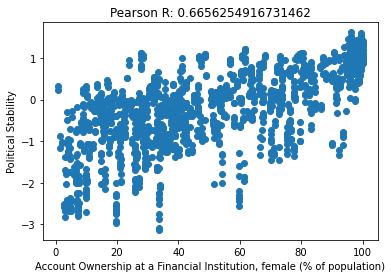

In [510]:
#get all correlations from filled_df_new dataframe
correlations = filled_df_new.corr()
#elect top 3 positive and negative correlations with political stability
top_3_pos_corrs = correlations['Political_Stability'].sort_values(ascending=False).head(4)
top_3_neg_corrs = correlations['Political_Stability'].sort_values(ascending=True).head(4)

#print out top correlations
print(top_3_pos_corrs)
print(top_3_neg_corrs)

#Set best_corr_value
best_corr_value = filled_df_new['Account ownership at a financial institution or with a mobile-money-service provider, female (% of population ages 15+)'].corr(filled_df_new['Political_Stability'])

#graph top correlation
#set x and y for scatterplot
x = filled_df_new['Account ownership at a financial institution or with a mobile-money-service provider, female (% of population ages 15+)']
y = filled_df_new['Political_Stability']

#Use scatterplot
plt.scatter(x, y)
#add title
plt.title('Pearson R: ' + str(best_corr_value))
plt.xlabel("Account Ownership at a Financial Institution, female (% of population)")
plt.ylabel("Political Stability")
plt.show()

Text(0.5, 1.0, 'Pearson R: 0.6656254916731462')

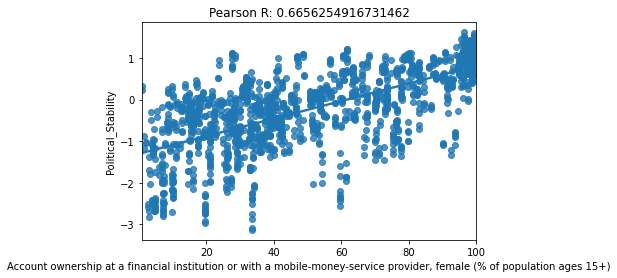

In [514]:
#Make plot using Seaborn which adds best fit line
import seaborn as sns
sns.regplot(x='Account ownership at a financial institution or with a mobile-money-service provider, female (% of population ages 15+)',
           y='Political_Stability', data=filled_df_new).set_title('Pearson R: ' + str(best_corr_value))

# Find Features that are correlated with each other and drop features 

In [420]:
#make a copy of filled_df_new
corr_filled_df = filled_df_new.copy()
corr_filled_df.head()

,country,Forest area (% of land area),Cereal yield (kg per hectare),Current account balance (% of GDP),"Foreign direct investment, net inflows (% of GDP)",Net official development assistance and official aid received (current US$),Access to clean fuels and technologies for cooking (% of population),Access to electricity (% of population),Renewable electricity output (% of total electricity output),CO2 emissions (metric tons per capita),...,Prevalence of anemia among women of reproductive age (% of women ages 15-49),"Mortality rate, under-5 (per 1,000 live births)","Mortality from CVD, cancer, diabetes or CRD between exact ages 30 and 70 (%)","Mortality rate, neonatal (per 1,000 live births)",People using at least basic drinking water services (% of population),"Suicide mortality rate (per 100,000 population)","Unemployment, total (% of total labor force) (modeled ILO estimate)",Urban population growth (annual %),"Intentional homicides (per 100,000 people)",Political_Stability
0,1,1.850994,2164.9,-19.656393,0.121323,4.284420e+09,32.44,97.700000,86.050111,0.200151,...,42.6,60.3,35.3,35.9,67.064623,4.1,10.98,3.323827,6.655561,-2.649407
1,1,1.850994,2164.9,-21.231682,0.650735,3.792450e+09,32.44,98.715622,86.050111,0.200151,...,41.8,62.5,35.4,36.9,67.064623,4.1,11.06,3.349934,6.655561,-2.751611
2,1,1.850994,2025.1,-18.838941,0.273100,3.811740e+09,32.44,97.700000,86.050111,0.203328,...,40.9,64.9,35.5,38.0,67.064623,4.1,11.18,3.462893,6.678401,-2.800609
3,1,1.850994,1981.9,-15.032194,0.519440,4.069420e+09,32.44,97.700000,86.050111,0.208857,...,40.2,67.6,35.6,39.1,64.286484,4.0,11.31,3.649128,6.551163,-2.671054
4,1,1.850994,2133.7,-21.061903,0.849679,4.274230e+09,30.10,71.500000,86.050111,0.232176,...,39.4,70.4,35.6,40.3,61.546930,4.0,11.39,3.951726,9.783922,-2.571222


In [421]:
#Find column pairs where correlation is greater than 0.8 and fill in missing values using the correlated column
for i in range(len(filled_df_new.columns)):
    for j in range(i):
        corr=filled_df_new[filled_df_new.columns[i]].corr(filled_df_new[filled_df_new.columns[j]])
        if corr > 0.7:
            col1_vals = filled_df_new[filled_df_new.columns[i]].values
            col2_vals = filled_df_new[filled_df_new.columns[j]].values
            for index1, col1_val in enumerate(col1_vals):
                if np.isnan(col1_val) and not np.isnan(col2_vals[index1]):
                    for index2, col2_val in enumerate(col2_vals):
                        if abs(col2_val-col2_vals[index1]) < (0.1*col2_vals[index1]) and not np.isnan(col1_vals[index2]) and index2 != index1:
                            col1_val = col1_vals[index2] 
            corr_filled_df[corr_filled_df.columns[i]] = col1_vals.tolist()

corr_filled_df.head()
                    

,country,Forest area (% of land area),Cereal yield (kg per hectare),Current account balance (% of GDP),"Foreign direct investment, net inflows (% of GDP)",Net official development assistance and official aid received (current US$),Access to clean fuels and technologies for cooking (% of population),Access to electricity (% of population),Renewable electricity output (% of total electricity output),CO2 emissions (metric tons per capita),...,Prevalence of anemia among women of reproductive age (% of women ages 15-49),"Mortality rate, under-5 (per 1,000 live births)","Mortality from CVD, cancer, diabetes or CRD between exact ages 30 and 70 (%)","Mortality rate, neonatal (per 1,000 live births)",People using at least basic drinking water services (% of population),"Suicide mortality rate (per 100,000 population)","Unemployment, total (% of total labor force) (modeled ILO estimate)",Urban population growth (annual %),"Intentional homicides (per 100,000 people)",Political_Stability
0,1,1.850994,2164.9,-19.656393,0.121323,4.284420e+09,32.44,97.700000,86.050111,0.200151,...,42.6,60.3,35.3,35.9,67.064623,4.1,10.98,3.323827,6.655561,-2.649407
1,1,1.850994,2164.9,-21.231682,0.650735,3.792450e+09,32.44,98.715622,86.050111,0.200151,...,41.8,62.5,35.4,36.9,67.064623,4.1,11.06,3.349934,6.655561,-2.751611
2,1,1.850994,2025.1,-18.838941,0.273100,3.811740e+09,32.44,97.700000,86.050111,0.203328,...,40.9,64.9,35.5,38.0,67.064623,4.1,11.18,3.462893,6.678401,-2.800609
3,1,1.850994,1981.9,-15.032194,0.519440,4.069420e+09,32.44,97.700000,86.050111,0.208857,...,40.2,67.6,35.6,39.1,64.286484,4.0,11.31,3.649128,6.551163,-2.671054
4,1,1.850994,2133.7,-21.061903,0.849679,4.274230e+09,30.10,71.500000,86.050111,0.232176,...,39.4,70.4,35.6,40.3,61.546930,4.0,11.39,3.951726,9.783922,-2.571222


In [422]:
#Find the number of null values per feature
corr_filled_df.isnull().sum()

country                                                                                                                      0
Forest area (% of land area)                                                                                                31
Cereal yield (kg per hectare)                                                                                              208
Current account balance (% of GDP)                                                                                         168
Foreign direct investment, net inflows (% of GDP)                                                                           88
Net official development assistance and official aid received (current US$)                                                578
Access to clean fuels and technologies for cooking (% of population)                                                       160
Access to electricity (% of population)                                                                        

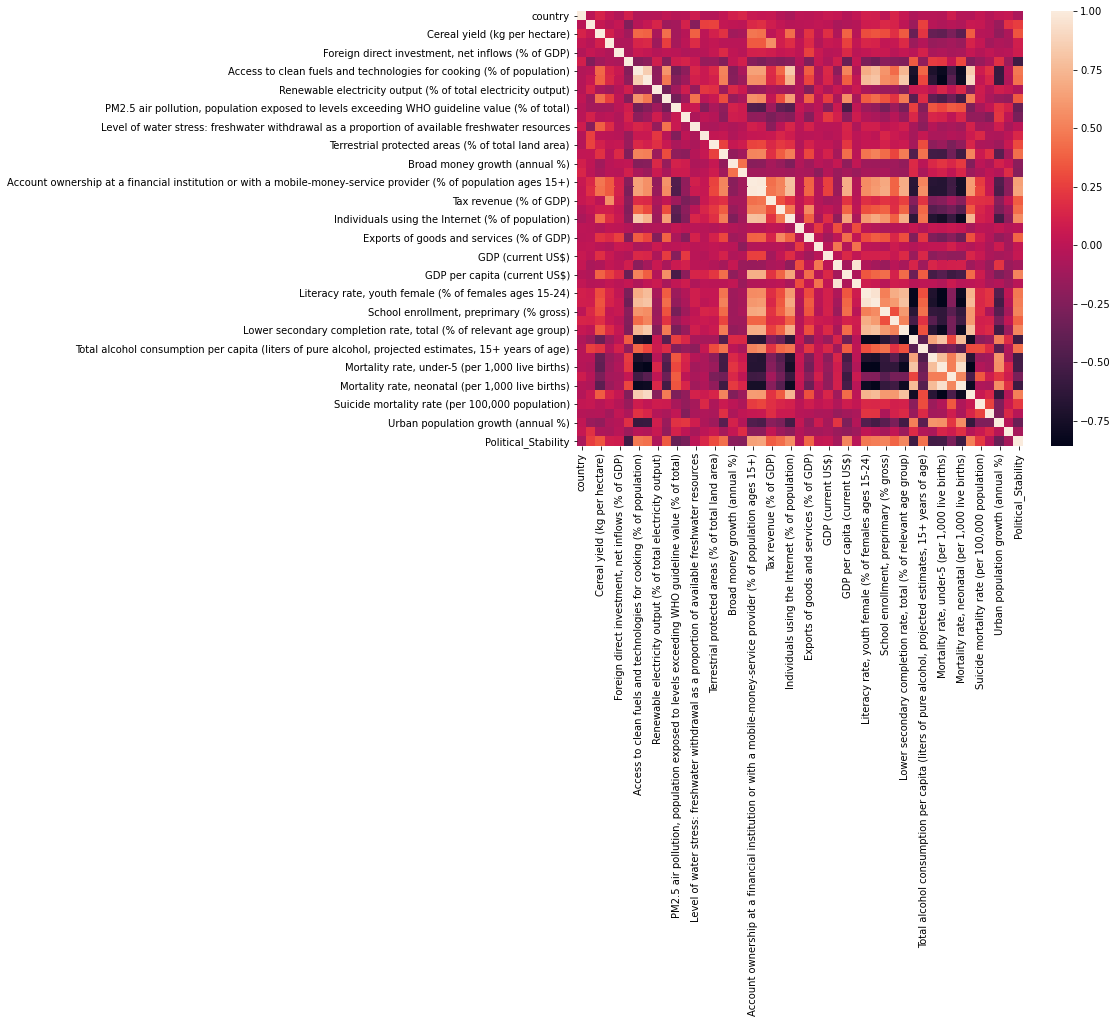

In [423]:
import matplotlib.pyplot as plt
import seaborn as sns

#Create Correlation Matrix
CorrMatrix = filled_df_new.corr()

plt.figure(figsize=(10,8))
sns.heatmap(CorrMatrix)
plt.show()

<ipython-input-424-0ce77629f95e>:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper_matrix = CorrMatrix.where(np.triu(np.ones(CorrMatrix.shape),k=1).astype(np.bool))


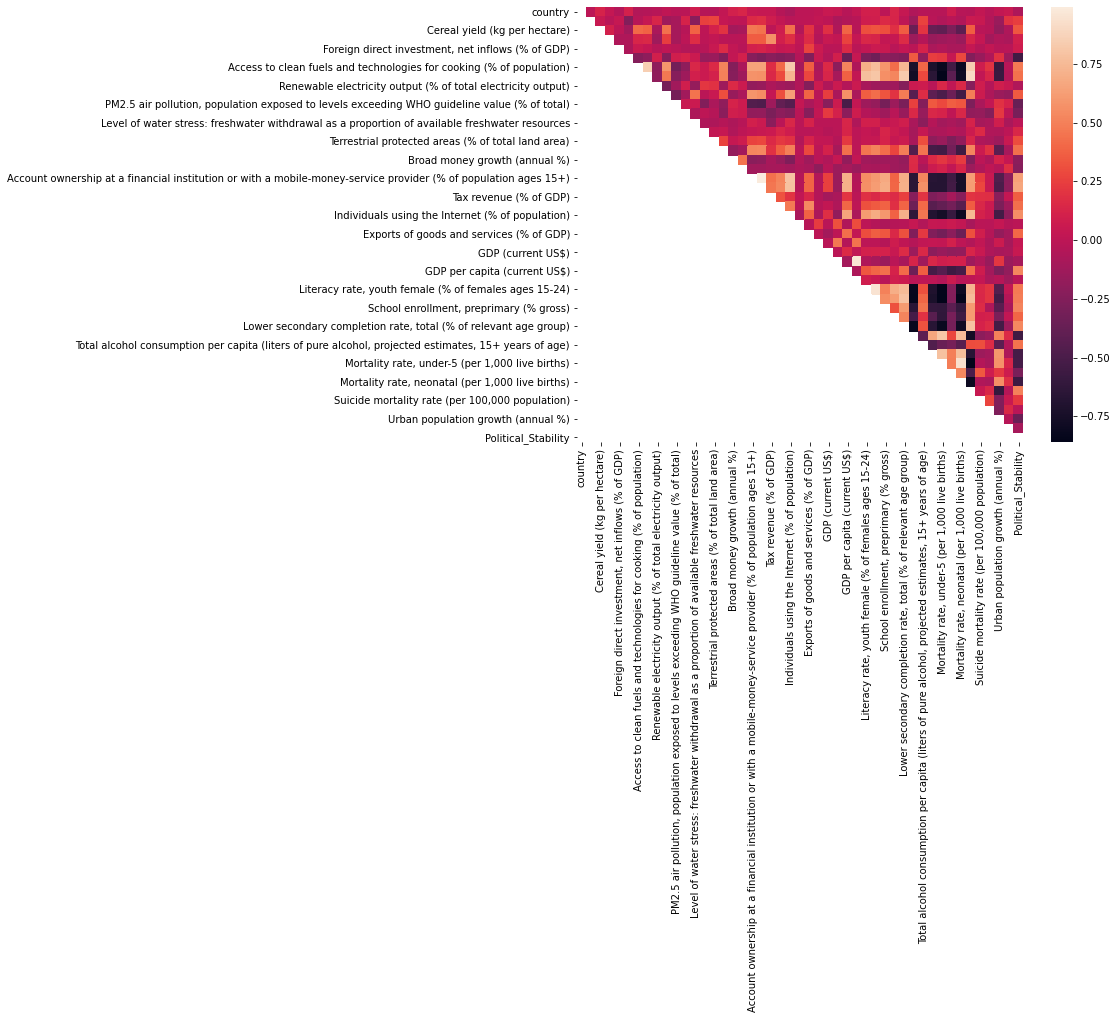

In [424]:
#Drop one feature if there is a high correlation
#import datasets from sklearn
from sklearn import datasets

#Get upper triangle of the correlation matrix since the bottom triangle is the same
upper_matrix = CorrMatrix.where(np.triu(np.ones(CorrMatrix.shape),k=1).astype(np.bool))

plt.figure(figsize=(10,8))
sns.heatmap(upper_matrix)
plt.show()


In [425]:
#Identify columns to drop where the correlation is greater than 0.8
to_drop = [column for column in upper_matrix.columns if any(upper_matrix[column] > 0.8)]
print(to_drop)

['Access to electricity (% of population)', 'Account ownership at a financial institution or with a mobile-money-service provider, female (% of population ages 15+)', 'Individuals using the Internet (% of population)', 'GDP per capita growth (annual %)', 'Literacy rate, adult total (% of people ages 15 and above)', 'Lower secondary completion rate, total (% of relevant age group)', 'Mortality rate, under-5 (per 1,000 live births)', 'Mortality rate, neonatal (per 1,000 live births)', 'People using at least basic drinking water services (% of population)']


In [426]:
#Drop the highly correlated columns from filled_df_new
df_uncorr = corr_filled_df.drop(to_drop, axis=1)
df_uncorr.head()

,country,Forest area (% of land area),Cereal yield (kg per hectare),Current account balance (% of GDP),"Foreign direct investment, net inflows (% of GDP)",Net official development assistance and official aid received (current US$),Access to clean fuels and technologies for cooking (% of population),Renewable electricity output (% of total electricity output),CO2 emissions (metric tons per capita),"PM2.5 air pollution, population exposed to levels exceeding WHO guideline value (% of total)",...,"School enrollment, primary and secondary (gross), gender parity index (GPI)",Adolescents out of school (% of lower secondary school age),"Total alcohol consumption per capita (liters of pure alcohol, projected estimates, 15+ years of age)",Prevalence of anemia among women of reproductive age (% of women ages 15-49),"Mortality from CVD, cancer, diabetes or CRD between exact ages 30 and 70 (%)","Suicide mortality rate (per 100,000 population)","Unemployment, total (% of total labor force) (modeled ILO estimate)",Urban population growth (annual %),"Intentional homicides (per 100,000 people)",Political_Stability
0,1,1.850994,2164.9,-19.656393,0.121323,4.284420e+09,32.44,86.050111,0.200151,100.0,...,0.63602,NaN,0.21,42.6,35.3,4.1,10.98,3.323827,6.655561,-2.649407
1,1,1.850994,2164.9,-21.231682,0.650735,3.792450e+09,32.44,86.050111,0.200151,100.0,...,0.63602,NaN,0.21,41.8,35.4,4.1,11.06,3.349934,6.655561,-2.751611
2,1,1.850994,2025.1,-18.838941,0.273100,3.811740e+09,32.44,86.050111,0.203328,100.0,...,0.64169,NaN,0.21,40.9,35.5,4.1,11.18,3.462893,6.678401,-2.800609
3,1,1.850994,1981.9,-15.032194,0.519440,4.069420e+09,32.44,86.050111,0.208857,100.0,...,0.64567,NaN,0.21,40.2,35.6,4.0,11.31,3.649128,6.551163,-2.671054
4,1,1.850994,2133.7,-21.061903,0.849679,4.274230e+09,30.10,86.050111,0.232176,100.0,...,0.64233,NaN,0.21,39.4,35.6,4.0,11.39,3.951726,9.783922,-2.571222


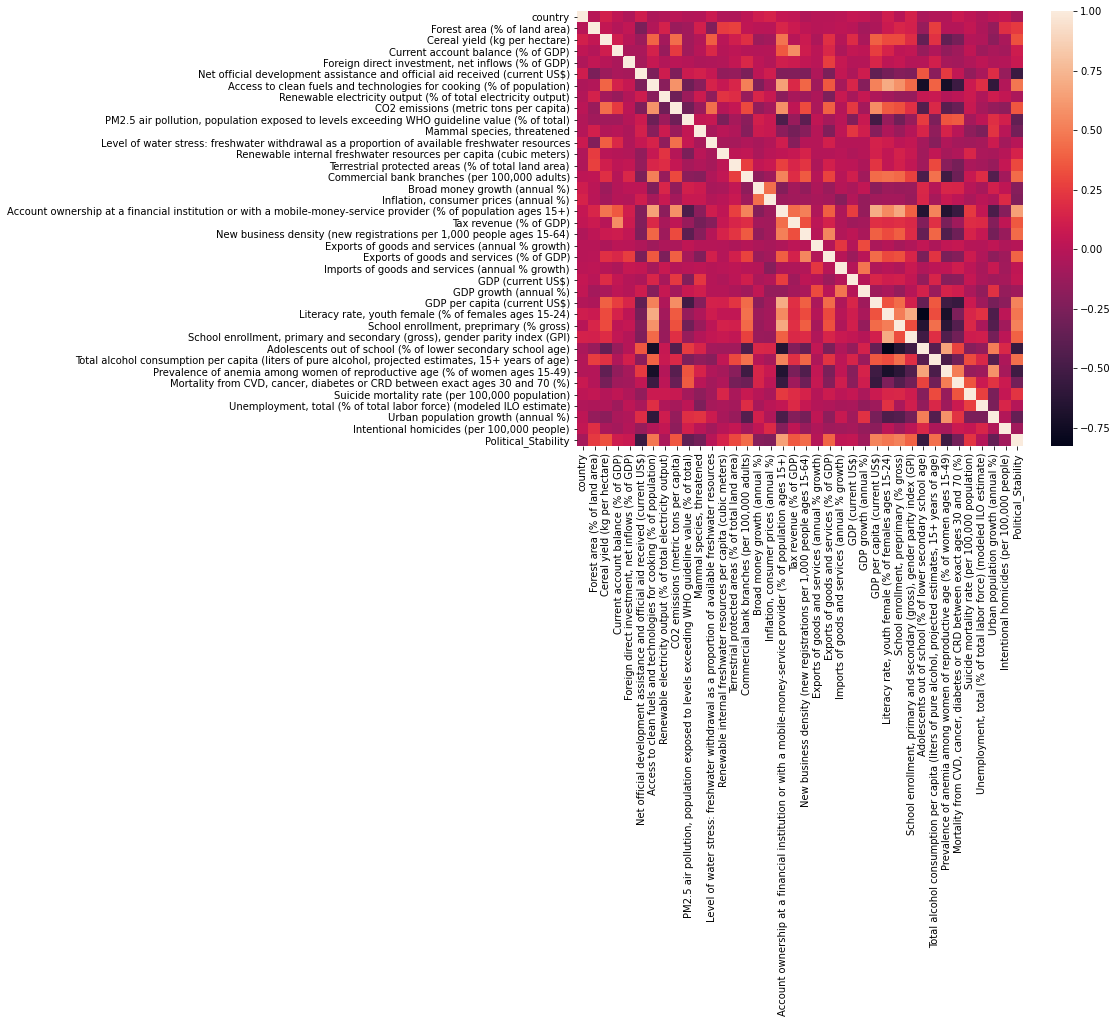

In [427]:
#Look at new correlation Matrix
new_corr_matrix = df_uncorr.corr()

plt.figure(figsize=(10,8))
sns.heatmap(new_corr_matrix)
plt.show()

# Use Unsupervised Learning to fill in remaining missing values after Clustering like countries

In [439]:
print(df_uncorr.shape)
#drop rows with more than 30% of the features missing in that row
threshold=0.7*df_uncorr.shape[1]
print(threshold)
mod_df = df_uncorr.dropna(axis=0, thresh=threshold)

mod_df.shape

(1927, 38)
26.599999999999998


(1769, 38)

In [440]:
#Find the number of null values per feature
mod_df.isnull().sum()

country                                                                                                              0
Forest area (% of land area)                                                                                         0
Cereal yield (kg per hectare)                                                                                       90
Current account balance (% of GDP)                                                                                  80
Foreign direct investment, net inflows (% of GDP)                                                                   20
Net official development assistance and official aid received (current US$)                                        450
Access to clean fuels and technologies for cooking (% of population)                                                40
Renewable electricity output (% of total electricity output)                                                         0
CO2 emissions (metric tons per capita)          

In [441]:
#A couple of columns still have high values for missing data, so we can drop those
new_drop_cols = ['Tax revenue (% of GDP)', 'Net official development assistance and official aid received (current US$)']
mod_df.drop(new_drop_cols, axis=1, inplace=True)
mod_df.shape

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


(1769, 36)

In [452]:
#remove features that have a lot of missing values that we want to fill in later using unsupervised learning
cols_to_impute = ['Cereal yield (kg per hectare)', 'Current account balance (% of GDP)', 'Level of water stress: freshwater withdrawal as a proportion of available freshwater resources', 'Renewable internal freshwater resources per capita (cubic meters)', 'Broad money growth (annual %)', 'Inflation, consumer prices (annual %)', 'Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+)', 'New business density (new registrations per 1,000 people ages 15-64)', 'Exports of goods and services (annual % growth)', 'Exports of goods and services (% of GDP)', 'Imports of goods and services (annual % growth)', 'Literacy rate, youth female (% of females ages 15-24)', 'School enrollment, preprimary (% gross)', 'School enrollment, primary and secondary (gross), gender parity index (GPI)', 'Adolescents out of school (% of lower secondary school age)', 'Unemployment, total (% of total labor force) (modeled ILO estimate)', 'Intentional homicides (per 100,000 people)']
df_cols_to_impute = mod_df[cols_to_impute]
df_cols_to_impute.head()

#set the features for the unsupervised learning model
features = mod_df.drop(cols_to_impute, axis=1)
features.drop('Political_Stability', axis=1, inplace=True)
features.drop('country', axis=1, inplace=True)

#set the target for the unsupervised learning model
y = mod_df['country']
y.head()

0    1
1    1
2    1
3    1
4    1
Name: country, dtype: int64

In [456]:
#fill in missing values in the features df with mean of column values
features.fillna(features.mean(), inplace=True)

In [457]:
#make sure there are no missing values
features.isnull().sum()

Forest area (% of land area)                                                                            0
Foreign direct investment, net inflows (% of GDP)                                                       0
Access to clean fuels and technologies for cooking (% of population)                                    0
Renewable electricity output (% of total electricity output)                                            0
CO2 emissions (metric tons per capita)                                                                  0
PM2.5 air pollution, population exposed to levels exceeding WHO guideline value (% of total)            0
Mammal species, threatened                                                                              0
Terrestrial protected areas (% of total land area)                                                      0
Commercial bank branches (per 100,000 adults)                                                           0
GDP (current US$)                             

In [464]:
#standardize the dataset
from sklearn.preprocessing import StandardScaler

#Standardize the dataset
sc = StandardScaler()
features_sc = sc.fit_transform(features)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(


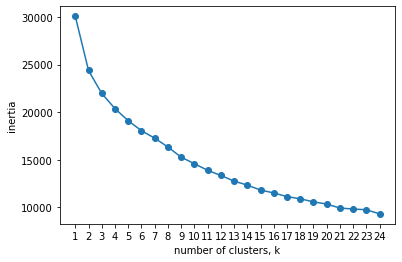

In [465]:
#Perform k-Means to cluster the data

#Find number of clusters using inertia
from sklearn.cluster import KMeans

ks = range(1, 25)
inertias = []

for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(features_sc)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [466]:
#set number of clusters to 11 using inertia elbow method
from sklearn.cluster import KMeans
model = KMeans(n_clusters=11)
labels = model.fit_predict(features_sc)

In [470]:
#add cluster label to features dataset
features['cluster_label']=labels.tolist()
features.head()

,Forest area (% of land area),"Foreign direct investment, net inflows (% of GDP)",Access to clean fuels and technologies for cooking (% of population),Renewable electricity output (% of total electricity output),CO2 emissions (metric tons per capita),"PM2.5 air pollution, population exposed to levels exceeding WHO guideline value (% of total)","Mammal species, threatened",Terrestrial protected areas (% of total land area),"Commercial bank branches (per 100,000 adults)",GDP (current US$),GDP growth (annual %),GDP per capita (current US$),"Total alcohol consumption per capita (liters of pure alcohol, projected estimates, 15+ years of age)",Prevalence of anemia among women of reproductive age (% of women ages 15-49),"Mortality from CVD, cancer, diabetes or CRD between exact ages 30 and 70 (%)","Suicide mortality rate (per 100,000 population)",Urban population growth (annual %),cluster_label
0,1.850994,0.121323,32.44,86.050111,0.200151,100.0,11.0,0.104707,1.87,1.929110e+10,3.911603,507.103392,0.21,42.6,35.3,4.1,3.323827,4
1,1.850994,0.650735,32.44,86.050111,0.200151,100.0,11.0,0.104707,1.96,1.835388e+10,1.189228,493.756581,0.21,41.8,35.4,4.1,3.349934,4
2,1.850994,0.273100,32.44,86.050111,0.203328,100.0,11.0,0.104707,2.04,1.886995e+10,2.647003,519.888913,0.21,40.9,35.5,4.1,3.462893,4
3,1.850994,0.519440,32.44,86.050111,0.208857,100.0,11.0,0.100000,2.11,1.801775e+10,2.260314,509.220100,0.21,40.2,35.6,4.0,3.649128,4
4,1.850994,0.849679,30.10,86.050111,0.232176,100.0,11.0,0.100000,2.16,1.990711e+10,1.451315,578.466353,0.21,39.4,35.6,4.0,3.951726,4


In [472]:
#join features dataset with df_cols_to_impute
final_features = pd.concat([features,df_cols_to_impute], axis=1)
final_features.head()

,Forest area (% of land area),"Foreign direct investment, net inflows (% of GDP)",Access to clean fuels and technologies for cooking (% of population),Renewable electricity output (% of total electricity output),CO2 emissions (metric tons per capita),"PM2.5 air pollution, population exposed to levels exceeding WHO guideline value (% of total)","Mammal species, threatened",Terrestrial protected areas (% of total land area),"Commercial bank branches (per 100,000 adults)",GDP (current US$),...,"New business density (new registrations per 1,000 people ages 15-64)",Exports of goods and services (annual % growth),Exports of goods and services (% of GDP),Imports of goods and services (annual % growth),"Literacy rate, youth female (% of females ages 15-24)","School enrollment, preprimary (% gross)","School enrollment, primary and secondary (gross), gender parity index (GPI)",Adolescents out of school (% of lower secondary school age),"Unemployment, total (% of total labor force) (modeled ILO estimate)","Intentional homicides (per 100,000 people)"
0,1.850994,0.121323,32.44,86.050111,0.200151,100.0,11.0,0.104707,1.87,1.929110e+10,...,0.211648,NaN,NaN,NaN,56.254749,NaN,0.63602,NaN,10.98,6.655561
1,1.850994,0.650735,32.44,86.050111,0.200151,100.0,11.0,0.104707,1.96,1.835388e+10,...,0.211648,NaN,NaN,NaN,56.254749,NaN,0.63602,NaN,11.06,6.655561
2,1.850994,0.273100,32.44,86.050111,0.203328,100.0,11.0,0.104707,2.04,1.886995e+10,...,0.154862,NaN,NaN,NaN,56.254749,NaN,0.64169,NaN,11.18,6.678401
3,1.850994,0.519440,32.44,86.050111,0.208857,100.0,11.0,0.100000,2.11,1.801775e+10,...,0.130028,NaN,NaN,NaN,56.254749,NaN,0.64567,NaN,11.31,6.551163
4,1.850994,0.849679,30.10,86.050111,0.232176,100.0,11.0,0.100000,2.16,1.990711e+10,...,0.124470,NaN,NaN,NaN,56.254749,NaN,0.64233,NaN,11.39,9.783922


In [475]:
#Group by label and fill missing values using mean of each group for each feature
filled_final_features = final_features.groupby("cluster_label").transform(lambda x: x.fillna(x.mean()))
filled_final_features.head()

,Forest area (% of land area),"Foreign direct investment, net inflows (% of GDP)",Access to clean fuels and technologies for cooking (% of population),Renewable electricity output (% of total electricity output),CO2 emissions (metric tons per capita),"PM2.5 air pollution, population exposed to levels exceeding WHO guideline value (% of total)","Mammal species, threatened",Terrestrial protected areas (% of total land area),"Commercial bank branches (per 100,000 adults)",GDP (current US$),...,"New business density (new registrations per 1,000 people ages 15-64)",Exports of goods and services (annual % growth),Exports of goods and services (% of GDP),Imports of goods and services (annual % growth),"Literacy rate, youth female (% of females ages 15-24)","School enrollment, preprimary (% gross)","School enrollment, primary and secondary (gross), gender parity index (GPI)",Adolescents out of school (% of lower secondary school age),"Unemployment, total (% of total labor force) (modeled ILO estimate)","Intentional homicides (per 100,000 people)"
0,1.850994,0.121323,32.44,86.050111,0.200151,100.0,11.0,0.104707,1.87,1.929110e+10,...,0.211648,6.589954,27.31067,7.923148,56.254749,34.044868,0.63602,28.002375,10.98,6.655561
1,1.850994,0.650735,32.44,86.050111,0.200151,100.0,11.0,0.104707,1.96,1.835388e+10,...,0.211648,6.589954,27.31067,7.923148,56.254749,34.044868,0.63602,28.002375,11.06,6.655561
2,1.850994,0.273100,32.44,86.050111,0.203328,100.0,11.0,0.104707,2.04,1.886995e+10,...,0.154862,6.589954,27.31067,7.923148,56.254749,34.044868,0.64169,28.002375,11.18,6.678401
3,1.850994,0.519440,32.44,86.050111,0.208857,100.0,11.0,0.100000,2.11,1.801775e+10,...,0.130028,6.589954,27.31067,7.923148,56.254749,34.044868,0.64567,28.002375,11.31,6.551163
4,1.850994,0.849679,30.10,86.050111,0.232176,100.0,11.0,0.100000,2.16,1.990711e+10,...,0.124470,6.589954,27.31067,7.923148,56.254749,34.044868,0.64233,28.002375,11.39,9.783922


In [476]:
#make sure there are no missing values
filled_final_features.isnull().sum()

Forest area (% of land area)                                                                                        0
Foreign direct investment, net inflows (% of GDP)                                                                   0
Access to clean fuels and technologies for cooking (% of population)                                                0
Renewable electricity output (% of total electricity output)                                                        0
CO2 emissions (metric tons per capita)                                                                              0
PM2.5 air pollution, population exposed to levels exceeding WHO guideline value (% of total)                        0
Mammal species, threatened                                                                                          0
Terrestrial protected areas (% of total land area)                                                                  0
Commercial bank branches (per 100,000 adults)           

In [478]:
#New business density column must have had all null values for one cluster, so it was unable to be filled in. Since that had a large number of missing values earlier, let's drop that column. 
filled_final_features.drop('New business density (new registrations per 1,000 people ages 15-64)', axis=1, inplace=True)

# Supervised Learning Models

## Simple Linear Regression Model

In [481]:
#Set X and y for the models
X = filled_final_features
print(X.shape)
y = mod_df['Political_Stability']
print(y.shape)

#import train test split
from sklearn.model_selection import train_test_split

#split the dataset into testing and training portions, with the testing portion making up 20% of the data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

(1769, 33)
(1769,)


In [482]:
from sklearn.preprocessing import StandardScaler

#Standardize the dataset
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

In [519]:
from sklearn.linear_model import LinearRegression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)

from sklearn.metrics import mean_squared_error as MSE
mse_model = MSE(y_test, y_pred)
rmse_model = mse_model**(1/2)
print("Linear Regression RMSE_Model = ", rmse_model)

#calculate r2 score
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print('Linear Regression R2 Score = ' , r2)

Linear Regression RMSE_Model =  0.6137627798769326
Linear Regression R2 Score =  0.5225093760241303


## Decision Tree Regressor

In [521]:
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor()
dtr.fit(X_train, y_train)
y_pred = dtr.predict(X_test)

from sklearn.metrics import mean_squared_error as MSE
mse_model = MSE(y_test, y_pred)
rmse_model = mse_model**(1/2)
print("Decision Tree Regression RMSE_Model = ", rmse_model)

#calculate r2 score
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print('Decision Tree Regression R2 Score = ' , r2)

Decision Tree Regression RMSE_Model =  0.7914895984691472
Decision Tree Regression R2 Score =  0.20593843465755945


In [522]:
#Tune Decision Tree Regressor
#get parameters of model
dtr.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [532]:
#Tune the model to reduce error

# Import GridSearchCV
from sklearn.model_selection import GridSearchCV

# Define the grid of hyperparameters 'params_dt'
params_dt = {'max_depth': [5, 6, 7, 8, 9, 10, 11, 12],'min_samples_leaf': [0.005, 0.01, 0.02, 0.04, 0.06, 0.08],'max_features': [0.2, 0.4,0.6, 0.8, 0.1, 0.2]}

# Instantiate a 10-fold CV grid search object 'grid_dt'
grid_dt = GridSearchCV(estimator=dtr,param_grid=params_dt, cv=10, n_jobs=-1)

# Fit 'grid_dt' to the training data
grid_dt.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=DecisionTreeRegressor(max_depth=9, max_features=0.6,
                                             min_samples_leaf=0.01),
             n_jobs=-1,
             param_grid={'max_depth': [5, 6, 7, 8, 9, 10, 11, 12],
                         'max_features': [0.2, 0.4, 0.6, 0.8, 0.1, 0.2],
                         'min_samples_leaf': [0.005, 0.01, 0.02, 0.04, 0.06,
                                              0.08]})

In [533]:
# Extract best hyperparameters from 'grid_dt'
best_hyperparams = grid_dt.best_params_
print('Best hyperparameters:\n', best_hyperparams)

Best hyperparameters:
 {'max_depth': 12, 'max_features': 0.8, 'min_samples_leaf': 0.005}


In [535]:
#fit the model again with the best parameters
dtr = DecisionTreeRegressor(max_depth=12, max_features=0.8, min_samples_leaf=0.005)
dtr.fit(X_train, y_train)
y_pred = dtr.predict(X_test)

from sklearn.metrics import mean_squared_error as MSE
mse_model = MSE(y_test, y_pred)
rmse_model = mse_model**(1/2)
print("Tuned Decision Tree Regression RMSE_Model = ", rmse_model)

#calculate r2 score
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print('Tuned Decision Tree Regression R2 Score = ' , r2)

Tuned Decision Tree Regression RMSE_Model =  0.4986382156574542
Tuned Decision Tree Regression R2 Score =  0.6848372571992897


Feature: 0, Score: 0.07589
Feature: 1, Score: 0.01519
Feature: 2, Score: 0.06197
Feature: 3, Score: 0.00939
Feature: 4, Score: 0.00396
Feature: 5, Score: 0.01159
Feature: 6, Score: 0.09736
Feature: 7, Score: 0.01348
Feature: 8, Score: 0.01344
Feature: 9, Score: 0.05402
Feature: 10, Score: 0.00092
Feature: 11, Score: 0.00515
Feature: 12, Score: 0.01296
Feature: 13, Score: 0.01379
Feature: 14, Score: 0.00322
Feature: 15, Score: 0.05164
Feature: 16, Score: 0.00547
Feature: 17, Score: 0.00109
Feature: 18, Score: 0.01414
Feature: 19, Score: 0.00078
Feature: 20, Score: 0.01004
Feature: 21, Score: 0.00022
Feature: 22, Score: 0.00000
Feature: 23, Score: 0.39718
Feature: 24, Score: 0.00000
Feature: 25, Score: 0.02034
Feature: 26, Score: 0.00000
Feature: 27, Score: 0.03565
Feature: 28, Score: 0.01153
Feature: 29, Score: 0.02839
Feature: 30, Score: 0.00778
Feature: 31, Score: 0.01557
Feature: 32, Score: 0.00784


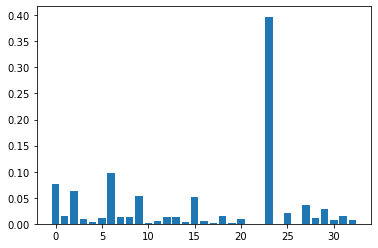

In [536]:
#Find what features are the most important for this model
importance = dtr.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [538]:
#Show column name for most important column
print(X.columns[23])

Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+)


## ETL Code

In [39]:
import psycopg2

# Connecting to the Postgres Server
conn = psycopg2.connect("user=postgres password=CLS521")
#make it so that every transaction is run independently and a rollback is done automatically if a transaction fails, otherwise a commit occurs.
conn.set_isolation_level(psycopg2.extensions.ISOLATION_LEVEL_AUTOCOMMIT);

In [40]:
# Get cursor object from the database connection
cursor = conn.cursor()

name_Database = "sustain_data"

# Create the crime data database
sqlCreateDatabase = "create database "+name_Database+";"

# Create a table in PostgreSQL database
#cursor.execute(sqlCreateDatabase);

In [41]:
# Connecting to the database (set a new connection)
conn = psycopg2.connect("dbname=sustain_data user=postgres password=CLS521")
#make it so that every transaction is run independently and a rollback is done automatically if a transaction failed, otherwise a commit occurs.
conn.set_isolation_level(psycopg2.extensions.ISOLATION_LEVEL_AUTOCOMMIT)
cursor = conn.cursor()